In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

- [x] Предобработка данных
- [x] Анализ данных о регистрациях и займах
- [x] Сколько времени проходит с момента начала регистрации до оформления первого займа
- [x] Срок займа: план-факт + динамика
- [x] Категоризация займов по реальному сроку пользования деньгами
- [x] Исследование суммы займов
- [x] Когортный анализ:
    - [x] User Retention
    - [x] Ср.кол-во займов нарастающим итогом
    - [x] Ср.сумма займа нарастающим итогом
    - [x] ARPU
    - [x] Ретеншен капитала
    - [x] NPL "наоборот"
    - [x] Накопительное среднее количество дней пользование кредитом на уникального клиента
- [ ] еще раз все просмотреть и структурировать
- [ ] кол-во займов, с разбивкой на персентили
- [ ] срок займа на пользователя, с разбивкой на персентили
- [ ] категоризировать по первому займу

# ЗАКИНУТЬ ИДЕЮ ПРО БЛОКИРОВКИ

## Чтение данных и объединение таблиц с данными о регистрациях

In [2]:
# читаем данные
regs1 = pd.read_excel('regs1.xlsx')
regs2 = pd.read_excel('regs2.xlsx')
loans = pd.read_excel('loans.xlsx')

In [3]:
# т.к данные с регистрациями предоставлены в 2ух файлах нам необходимо объеденить их в 1
regs = regs1.append(regs2, ignore_index=True)

## Предобработка данных

### Регистрации

In [4]:
# посмотрим на общую информацию
regs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1685056 entries, 0 to 1685055
Data columns (total 3 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   cid              1685056 non-null  int64         
 1   reg_date         1685056 non-null  datetime64[ns]
 2   is_reg_complete  1685056 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 38.6 MB


In [5]:
# изучим срез данных
regs.sample(5)

,cid,reg_date,is_reg_complete
336305,3221307,2019-03-23,1
1360308,4381223,2020-05-18,1
1673227,4694516,2020-11-24,1
1615827,4637020,2020-10-26,0
782889,3765390,2019-07-30,1


<b>cid</b> - id клиента<br>
<b>reg_date</b> - дата начала регистрации<br>
<b>is_reg_complete</b> - отметка о завершени регистрации<br>

In [6]:
# проверим таблицу на наличие пропусков и дубликатов
display(regs.isna().sum())
display(regs.duplicated().sum())

cid                0
reg_date           0
is_reg_complete    0
dtype: int64

0

<div class="alert alert-block alert-success">
<b>Вывод:</b> пропусков и дублей нет, двигаемся дальше
</div>

### Займы

In [7]:
# посмотрим на общую информацию
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465315 entries, 0 to 465314
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   cid         465315 non-null  int64         
 1   start_date  448305 non-null  datetime64[ns]
 2   value       465315 non-null  float64       
 3   term        465315 non-null  int64         
 4   status      465315 non-null  object        
 5   end_date    332380 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(1)
memory usage: 21.3+ MB


In [8]:
# изучим срез данных
loans.sample(5)

,cid,start_date,value,term,status,end_date
231915,3807696,2020-08-16,15000.0,10,Погашен,2020-08-30
313189,4136371,2020-01-29,2000.0,10,Погашен,2020-02-10
114369,3263763,2019-03-29,8000.0,30,Погашен,2019-04-15
123821,3322785,2019-08-03,6955.0,40,Погашен,2019-08-28
109976,3242357,NaT,14000.0,30,Отменён,NaT


In [9]:
# проверим таблицу на наличие пропусков и дубликатов
display(loans.isna().sum())
display(loans.duplicated().sum())

cid                0
start_date     17010
value              0
term               0
status             0
end_date      132935
dtype: int64

1872

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <li> нужно избавиться от пропусков в столбце start_date тк займ без даты начала не имеет для нас ценности
    <li> с пропусками в end_date ничего делать будем
    <li> также избавимся от дублей
</div>

In [10]:
# удаляем пропуски из столбца start_date
loans.dropna(subset=['start_date'], inplace=True)

# проверяем
loans.isna().sum()

cid                0
start_date         0
value              0
term               0
status             0
end_date      115925
dtype: int64

In [11]:
# теперь избавимся от дублей
loans.drop_duplicates(inplace=True)
loans.duplicated().sum()

0

<div class="alert alert-block alert-success">
<b>Вывод:</b> этап предобработки завершен, переходим к анализу
</div>

## Аналитика данных

### 1. Анализ данных о регистрациях и займах. Динамика по времени, конверсия + графики

Нам нужна таблица, в которой будут данные в динамике по месяцам:
- Общее кол-во регистраций
- Кол-во успешных (завершенных) регистраций
- Общее кол-во займов
- Кол-во новых займов
- Кол-во повторных займов

#### 1.1 Групиировка данных о регистарциях

In [12]:
# добавим в таблицу regs столбец reg_month - месяц регистрации пользователя
regs['reg_month'] = regs['reg_date'].astype('datetime64[M]')

# проверяем
regs.sample(5)

,cid,reg_date,is_reg_complete,reg_month
567077,3509193,2019-05-03,1,2019-05-01
131649,2983326,2019-01-31,1,2019-01-01
470626,3389970,2019-04-15,0,2019-04-01
1387232,4408152,2020-06-02,1,2020-06-01
382206,3276988,2019-03-30,1,2019-03-01


In [13]:
# сгруппируем данные по месяцам, посчитаем общее кол-во регистраци и кол-во успешных регистраций
regs_by_month = regs.groupby(by='reg_month').agg({'cid': 'nunique', 'is_reg_complete': 'sum'})
regs_by_month.columns = ['total_regs', 'success_regs']

# смотрим
regs_by_month

,total_regs,success_regs
reg_month,,
2019-01-01,133531,87889
2019-02-01,111882,69732
2019-03-01,144595,89224
2019-04-01,162872,99949
2019-05-01,76872,51432
2019-06-01,60268,41303
2019-07-01,100521,66543
2019-08-01,90094,58371
2019-09-01,20201,14530


#### 1.2 Групиировка данных о займах

In [14]:
# добавим в таблицу loans столбец с месяцев получения займа- loan_month

loans['loan_month'] = loans['start_date'].astype('datetime64[M]')

# проверяем
loans.sample(5)

,cid,start_date,value,term,status,end_date,loan_month
386874,4415376,2020-10-04,15000.0,10,Погашен,2020-10-13,2020-10-01
451302,4628633,2020-10-22,10000.0,15,Погашен,2020-12-02,2020-10-01
281858,4015410,2019-12-09,4440.0,30,На цессии,NaT,2019-12-01
169729,3542267,2019-08-23,8000.0,15,Погашен,2019-09-24,2019-08-01
210060,3713301,2019-07-31,10000.0,15,Погашен,2019-08-15,2019-07-01


In [15]:
# для каждого юзера найдем месяц первого займа
new_loans_by_month = loans.sort_values(by=['cid', 'start_date']).groupby(by='cid').agg({'loan_month': 'first'}).reset_index()

# сгруппируем данные по месяцам и подсчитаем кол-во уникальны займов
new_loans_by_month = new_loans_by_month.groupby(by='loan_month').agg({'cid': 'count'})
new_loans_by_month.columns = ['new_loans']

# проверяем
new_loans_by_month

,new_loans
loan_month,
2019-01-01,7957
2019-02-01,8879
2019-03-01,12222
2019-04-01,13328
2019-05-01,7258
2019-06-01,4995
2019-07-01,10059
2019-08-01,8585
2019-09-01,4140


In [16]:
# теперь посчитаем общее кол-во займов по месяцам
total_loans_by_month = loans.groupby(by='loan_month').agg({'cid': 'count'})
total_loans_by_month.columns = ['total_loans']

# проверяем
total_loans_by_month

,total_loans
loan_month,
2019-01-01,9157
2019-02-01,13419
2019-03-01,20770
2019-04-01,23864
2019-05-01,16360
2019-06-01,13091
2019-07-01,19330
2019-08-01,19683
2019-09-01,13197


In [17]:
# объеденим таблицы total_loans_by_month и new_loans_by_month
loans_by_month = pd.merge(total_loans_by_month, new_loans_by_month, on='loan_month')

# рассчитаем кол-во повторных займов
loans_by_month['repeated_loans'] = loans_by_month['total_loans'] - loans_by_month['new_loans']

# проверяем
loans_by_month

,total_loans,new_loans,repeated_loans
loan_month,,,
2019-01-01,9157,7957,1200
2019-02-01,13419,8879,4540
2019-03-01,20770,12222,8548
2019-04-01,23864,13328,10536
2019-05-01,16360,7258,9102
2019-06-01,13091,4995,8096
2019-07-01,19330,10059,9271
2019-08-01,19683,8585,11098
2019-09-01,13197,4140,9057


#### 1.3 Объеденение данных в обну таблицу

In [18]:
total_grouped_data = pd.merge(regs_by_month, loans_by_month, left_index=True, right_index=True)

total_grouped_data

,total_regs,success_regs,total_loans,new_loans,repeated_loans
2019-01-01,133531,87889,9157,7957,1200
2019-02-01,111882,69732,13419,8879,4540
2019-03-01,144595,89224,20770,12222,8548
2019-04-01,162872,99949,23864,13328,10536
2019-05-01,76872,51432,16360,7258,9102
2019-06-01,60268,41303,13091,4995,8096
2019-07-01,100521,66543,19330,10059,9271
2019-08-01,90094,58371,19683,8585,11098
2019-09-01,20201,14530,13197,4140,9057
2019-10-01,47373,35325,14844,6106,8738


#### 1.4 Визуализация

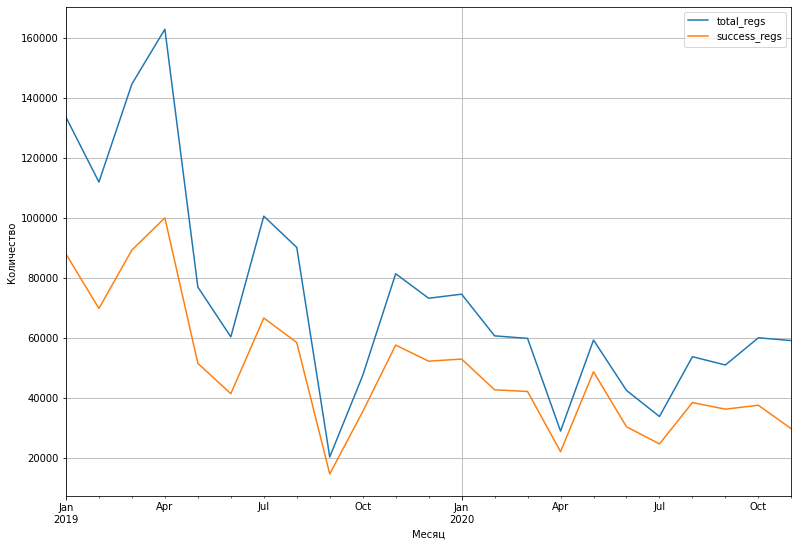

In [19]:
# динамика регистраций по месяцам
total_grouped_data[['total_regs', 'success_regs']].plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('Количество');

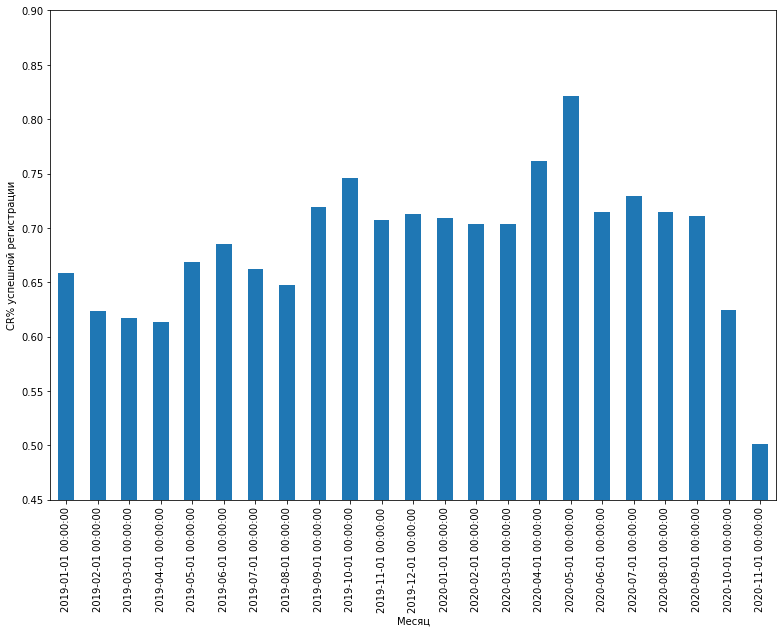

In [20]:
# динамика конверсии из все регистраций в успешные по месяцам
(total_grouped_data['success_regs'] / total_grouped_data['total_regs']).plot(figsize=(13, 9), kind='bar');
plt.ylim(0.45, 0.9)
plt.xlabel('Месяц');
plt.ylabel('CR% успешной регистрации');

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li> кол-во завершенных регистраций повторяет график общего уол-ва регистраций. 
        <li> конверсия из регистрации в успешную регистрацию колеблется в диапазоне от 62% до 72%, но иногда происходят скачки
    </ul>
</div>

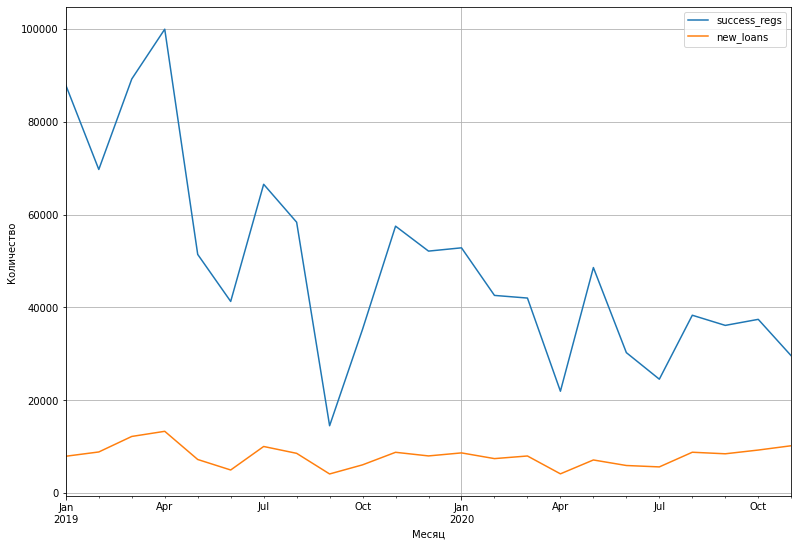

In [21]:
# теперь на одном графике сравним динамику успешных регистраций и новых займов
total_grouped_data[['success_regs', 'new_loans']].plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('Количество');

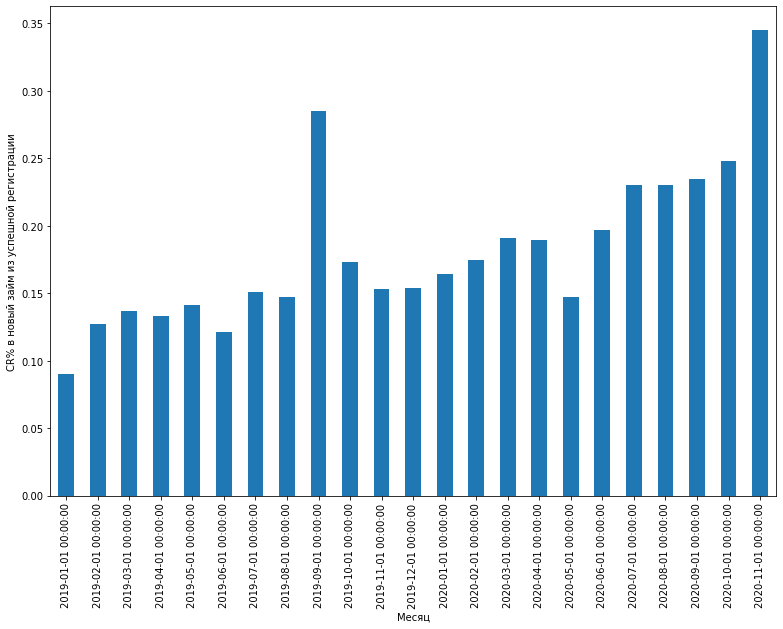

In [22]:
# а также посмотрим на конверсию в динамике
(total_grouped_data['new_loans'] / total_grouped_data['success_regs']).plot(figsize=(13, 9), kind='bar');
plt.xlabel('Месяц');
plt.ylabel('CR% в новый займ из успешной регистрации');

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li> кол-вл успешных регистраций на протяжении всего периода снижается
        <li> при этом мы видим, что новые выдачи повторяют график, но перепады не настолько значимы
        <li> частично это можно объяснить тем, что менялась форма регистрации и "успешной" в разные моменты времени регистрация оценивается по-разному
        <li> в последние 6 месяцев анализируемого периода конверсия находится на х1.5-2 от уровня предыдущего периода
    </ul>
</div>

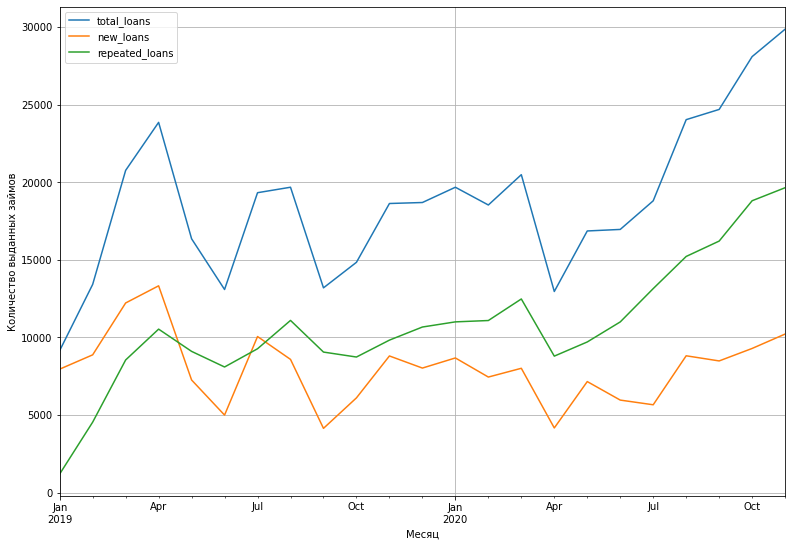

In [23]:
# посмотрим на долю разных типов займов в динамике
total_grouped_data[['total_loans', 'new_loans', 'repeated_loans']].plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('Количество выданных займов');

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li> даже с учетом весеннего локдауна практически нет просадки в цифрых
        <li> с апреля 2020 наблюдается стабильный рост показателей как новых так и повторных выдач
        <li> доля повторных займов составляет около 66% и растет быстрее новых - это хорошо
    </ul>
</div>

### 2. Сколько времени проходит с момента начала регистрации до оформления первого займа

In [24]:
# для начала из таблицы loans нам нужно получить для каждого юзера данные о его первом займе
first_loan_ts = loans.sort_values(by=['cid', 'start_date']).groupby(by='cid').agg({'start_date': 'first'}).reset_index()
first_loan_ts.columns=['cid', 'first_loan_date']

# проверяем
first_loan_ts.head()

,cid,first_loan_date
0,2825209,2019-01-01
1,2825218,2019-01-01
2,2825225,2019-03-30
3,2825230,2020-09-12
4,2825232,2019-07-27


In [25]:
# теперь добавим эти данные в таблицу с регистрациями
time_to_loan = pd.merge(regs, first_loan_ts, how='left', on='cid')

# посмотрим на случайные 20 записей из получившейся таблицы
time_to_loan.sample(20)

,cid,reg_date,is_reg_complete,reg_month,first_loan_date
558367,3498441,2019-05-02,1,2019-05-01,NaT
940893,3956284,2019-10-29,1,2019-10-01,2019-11-05
136909,2989471,2019-02-01,0,2019-02-01,NaT
901282,3904648,2019-10-02,1,2019-10-01,NaT
398719,3297275,2019-04-02,1,2019-04-01,NaT
507429,3436109,2019-04-22,1,2019-04-01,NaT
1085547,4101816,2019-12-24,1,2019-12-01,NaT
946233,3961670,2019-10-31,0,2019-10-01,NaT
169908,3027728,2019-02-09,1,2019-02-01,NaT
1440423,4461372,2020-07-13,1,2020-07-01,2020-11-26


<div class="alert alert-block alert-info">
<b>Важно:</b> во многих строках столбца start_loan появились значения NaT. Это говорит о том, что клиент начал регистрацию, но в итоге ни одного займа не получил. Избавимся от этих строк</div>

In [26]:
# удаляем лишние строки
time_to_loan.dropna(subset=['first_loan_date'], inplace=True)

# добавим в таблицу новый столбец с кол-во дней с начала регистрации до первого займа
time_to_loan['days_to_loan'] = (time_to_loan['first_loan_date'] - time_to_loan['reg_date']).dt.days

time_to_loan.sample(10)

,cid,reg_date,is_reg_complete,reg_month,first_loan_date,days_to_loan
1255708,4276389,2020-03-09,1,2020-03-01,2020-03-09,0
1540501,4561483,2020-09-15,1,2020-09-01,2020-09-15,0
795037,3779400,2019-08-02,1,2019-08-01,2019-08-05,3
608698,3560234,2019-05-15,1,2019-05-01,2019-05-15,0
33114,2863566,2019-01-09,1,2019-01-01,2019-01-09,0
220016,3084559,2019-02-22,1,2019-02-01,2019-06-21,119
1482909,4503867,2020-08-15,1,2020-08-01,2020-09-23,39
1545577,4566562,2020-09-19,1,2020-09-01,2020-09-19,0
964713,3980321,2019-11-06,1,2019-11-01,2019-12-31,55
1437226,4458174,2020-07-10,1,2020-07-01,2020-07-15,5


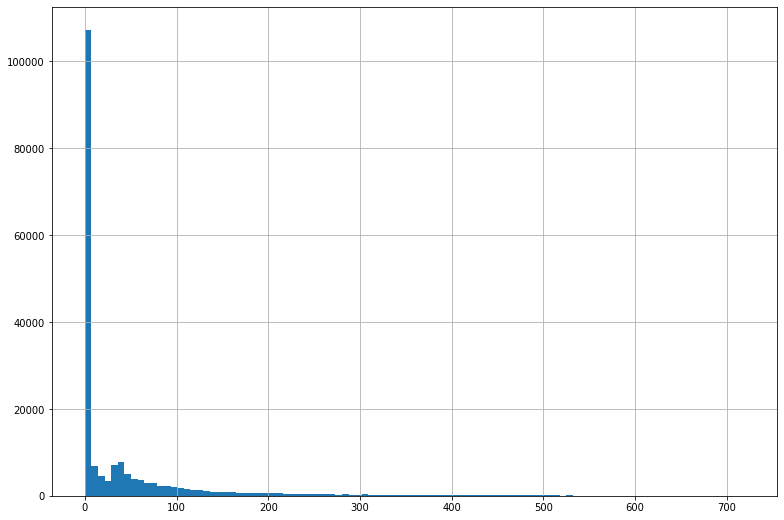

In [27]:
# построим гистограмму
time_to_loan['days_to_loan'].hist(figsize=(13, 9), bins=100);

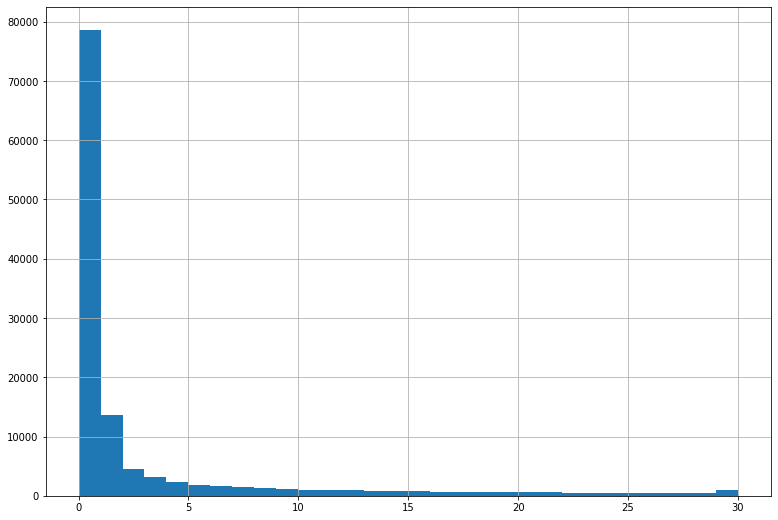

In [28]:
# львиная доля значений лежит в диапазоне от 0 до 30 дней, ограничим гистограмму этими значениями
time_to_loan['days_to_loan'].hist(figsize=(13, 9), bins=30, range=(0, 30));

In [29]:
# посмотрим на ТОП10 значений
time_to_loan['days_to_loan'].value_counts().head(10)

0     78616
1     13644
2      4490
3      3248
4      2284
5      1817
6      1622
7      1468
32     1324
8      1299
Name: days_to_loan, dtype: int64

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li> львиная доля клиентов получают свой первый заем в день регистрации
        <li> кол-во выдач на следующий день относительно большое, но это в т.ч. может быть связано с займами, которые оформляются в вечернее время и выдаются уже на следующий день
        <li> есть небольшой скачок на 32 день. Скорее всего это связано с разблокировкой спустя 30 дней
        <li> чем дальше от времени регистрации тем меньше шанс, что клиент оформит свой первый заем
        <li> в качестве рекомендации - нужно стараться максимально быстро конвертировать регистрацию в первый заем
    </ul>
</div>

### 3. Исследвание срока займа (план, факт) + динамика по месяцам

#### 3.1 Запрашиваемые и фактические значения займов

In [30]:
# рассчитаем фактический срок пользования деньгами
loans['real_term'] = (loans['end_date'] - loans['start_date']).dt.days

# удалим пустые значения т.к. нам нужны только те займы, которые уже погашены и сохраним данные в отдельный датафрейм
real_term = loans.query('real_term.notna()')
real_term['real_term'] = real_term['real_term'].astype('int')

# проверим на выборке
real_term.sample(10)

,cid,start_date,value,term,status,end_date,loan_month,real_term
442938,4592659,2020-10-26,19000.0,40,Погашен,2020-11-16,2020-10-01,21
261761,3945531,2020-05-21,8000.0,28,Погашен,2020-06-30,2020-05-01,40
345868,4259691,2020-03-26,6500.0,10,Погашен,2020-08-05,2020-03-01,132
380843,4397788,2020-05-28,5175.0,30,Погашен,2020-07-15,2020-05-01,48
15915,2878714,2019-04-07,8000.0,30,Погашен,2019-05-07,2019-04-01,30
20376,2894036,2019-04-01,3500.0,16,Погашен,2019-04-25,2019-04-01,24
153828,3463790,2019-05-17,3500.0,20,Погашен,2019-06-07,2019-05-01,21
216413,3739891,2019-07-25,6500.0,15,Погашен,2019-08-09,2019-07-01,15
14435,2873421,2019-01-10,3000.0,22,Погашен,2019-01-26,2019-01-01,16
95546,3185073,2020-10-16,2500.0,30,Погашен,2020-11-05,2020-10-01,20


In [31]:
# сравним сумму дней из запросов пользователей с суммой фактических дней пользования кредитом
print(f'Всего займов было оформлено на {real_term["term"].sum():,} дня(ей)')
print(f'Фактически, с учетом досрочных погашений и просрочек деньгами пользовались {real_term["real_term"].sum():,} дня(ей)')

Всего займов было оформлено на 9,770,892 дня(ей)
Фактически, с учетом досрочных погашений и просрочек деньгами пользовались 10,801,384 дня(ей)


<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li> Суммарный фактичесий срок пользования деньгами на 10,5% (или 1,030,492 дней) больше, чем все суммарные запрошенные значения. Это даже с учетом займов, которые погашаются досрочно (спойлер: их достаточно много)
    </ul>
</div>

#### 3.2 Распределение показателей, среднее значение, медиана, мода

count    332380.000000
mean         29.396751
std          21.902999
min           7.000000
25%          15.000000
50%          30.000000
75%          36.000000
max         168.000000
Name: term, dtype: float64

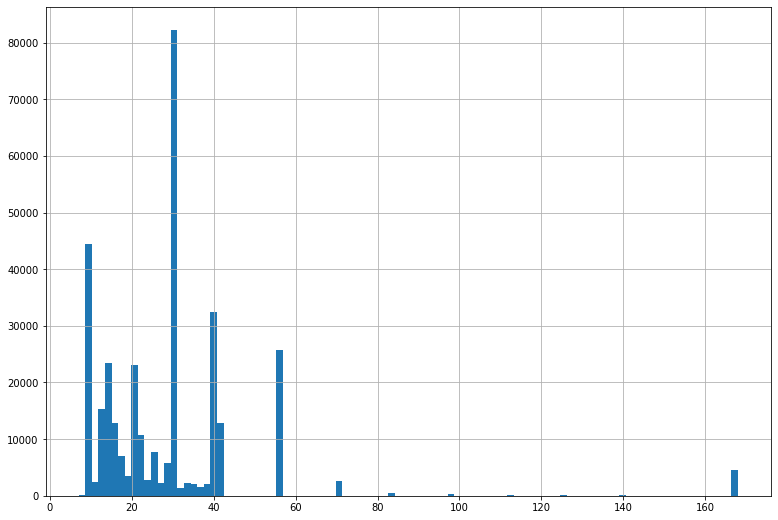

In [32]:
# распределение запрашиваемых сроков займов
display(real_term['term'].describe())
real_term['term'].hist(bins=100, figsize=(13, 9));

count    332380.000000
mean         32.497094
std          39.830470
min           0.000000
25%           8.000000
50%          20.000000
75%          42.000000
max         689.000000
Name: real_term, dtype: float64

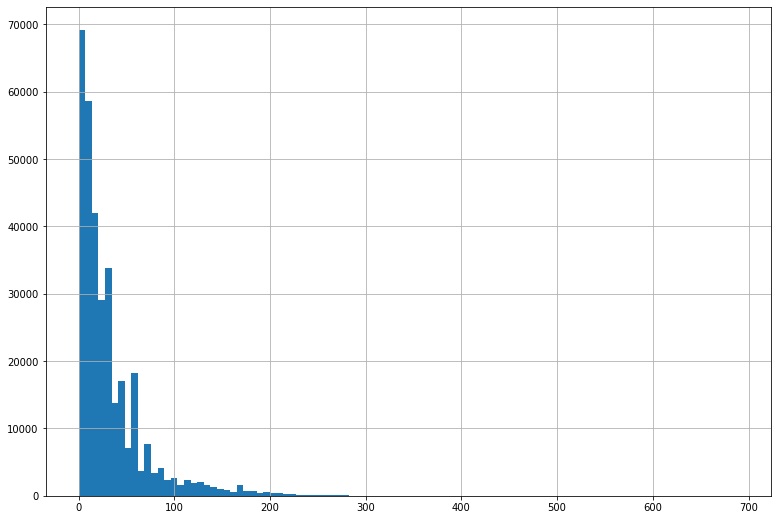

In [33]:
# распределение фактических сроков пользования займом
display(real_term['real_term'].describe())
real_term['real_term'].hist(bins=100, figsize=(13, 9));

In [34]:
# ТОП10 запрашиваемых сроков
real_term['term'].value_counts().head(10)

30    78227
10    44409
40    32414
56    25774
20    17957
15    16517
42    12836
16    12782
12    12482
23     7655
Name: term, dtype: int64

In [35]:
# ТОП10 фактических сроков
real_term['real_term'].value_counts().head(10)

1     12142
0     11770
10    11750
56    11024
2     10208
30    10074
3      9639
42     9096
4      8887
5      8402
Name: real_term, dtype: int64

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li> графики распределения отличаются очень сильно. Это говорит о том, что то, как люди планируют возвращать деньги и то, как они их возвращают - это разные значения
        <li> также на распределение оказывает влияение то, что запрашиваемый срок займа строго ограничен
        <li> среднее значение фактического пользования займом = 32.5 дня, средний запрашиваемый срок = 29.4 дня
        <li> медианное значение больше уже у запрашиваемых показателй - 30 дней против 20 дней. Т.е. 50% займов закрываются в срок до 20 дней
        <li> в ТОП10 значений фактического пользования займами 60% значений находится в диапазоне от 0 до 5 дней
        <li> 25% займов погашаются до 8 дней, 50% до 20 дней, 75% до 42 дней. Над этими показателями стоило бы поработать
    </ul>
</div>

#### 3.3 Динамка планового и фактического срока пользования деньгами

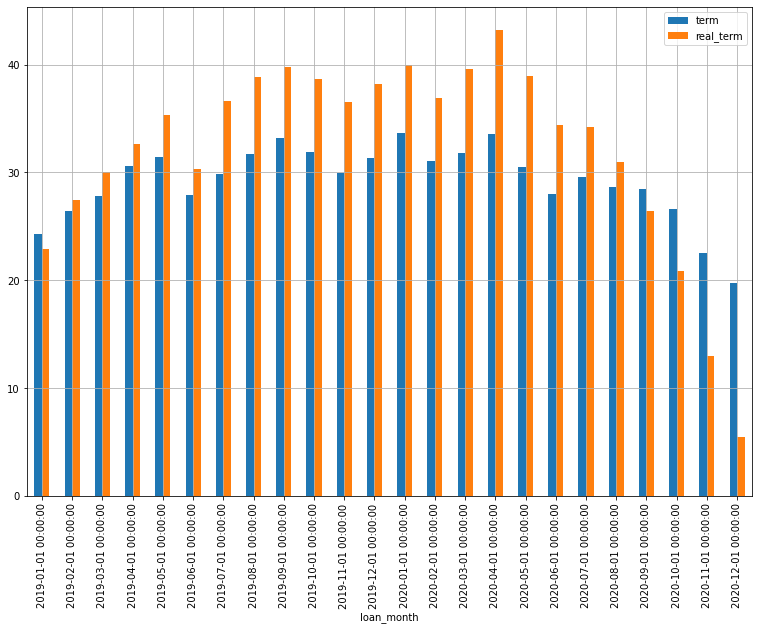

In [36]:
real_term.groupby('loan_month').agg({'term': 'mean', 'real_term': 'mean'}).plot(kind='bar', figsize=(13, 9), grid=True);

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li> весь 2019 год средний срок пользовния деньгами показывал положительную динамику
        <li> в этот же период мы видим значительно большой рост факт.пользования отностилеьно плана
        <li> начиная с апреля 2020 график идет вниз, но это скорее всего связано с тем, что часть клиентов из просрочки еще не вернули деньги (но согласно статистике обязательно вернут) либо доля досрочных погашений выросла
        <li> в дальнейшем посомотрим еще на эти показатели в когортах
    </ul>
</div>

### 4. Категоризация займов по реальному сроку пользования деньгами

In [37]:
# созданим функцию категоризации срока закрытия займа
def set_term_category(row):
    if row['real_term'] == row['term']:
        return 'В срок'
    elif row['real_term'] < row['term']:
        return 'Досрочно'
    elif row['real_term'] > row['term']:
        return 'С просрочкой'
    return 'Не закрыт'

In [38]:
# применяем функцию
loans['term_category'] = loans.apply(set_term_category, axis=1)

# проверяем
loans.sample(10)

,cid,start_date,value,term,status,end_date,loan_month,real_term,term_category
358036,4305808,2020-03-21,4000.0,30,Просрочен,NaT,2020-03-01,NaN,Не закрыт
267112,3963975,2019-11-01,9768.0,40,Просрочен,NaT,2019-11-01,NaN,Не закрыт
343293,4249648,2020-08-30,8050.0,37,Просрочен,NaT,2020-08-01,NaN,Не закрыт
72410,3093470,2019-03-21,12400.0,25,Погашен,2019-04-15,2019-03-01,25.0,В срок
323318,4174381,2020-03-27,3500.0,10,Погашен,2020-03-31,2020-03-01,4.0,Досрочно
80196,3124943,2020-08-06,6000.0,10,Погашен,2020-08-10,2020-08-01,4.0,Досрочно
117230,3277703,2019-04-30,7500.0,25,Погашен,2019-05-24,2019-04-01,24.0,Досрочно
85515,3144311,2020-08-04,2000.0,22,Погашен,2020-08-20,2020-08-01,16.0,Досрочно
176327,3569798,2020-07-31,14835.0,40,Погашен,2020-08-06,2020-07-01,6.0,Досрочно
42749,2981657,2019-04-06,6500.0,30,Погашен,2019-06-14,2019-04-01,69.0,С просрочкой


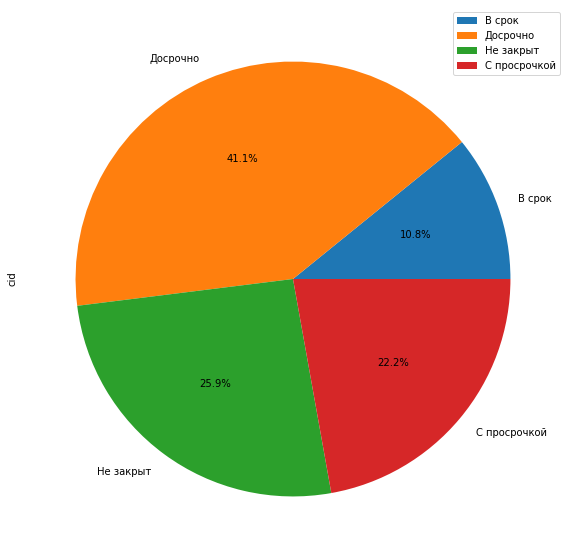

In [39]:
# построим круговую диаграмму для визуализации разделения займов по типам погашения
loans.groupby('term_category').agg({'cid': 'count'}).plot(kind='pie', subplots=True, figsize=(10, 10), autopct='%1.1f%%');

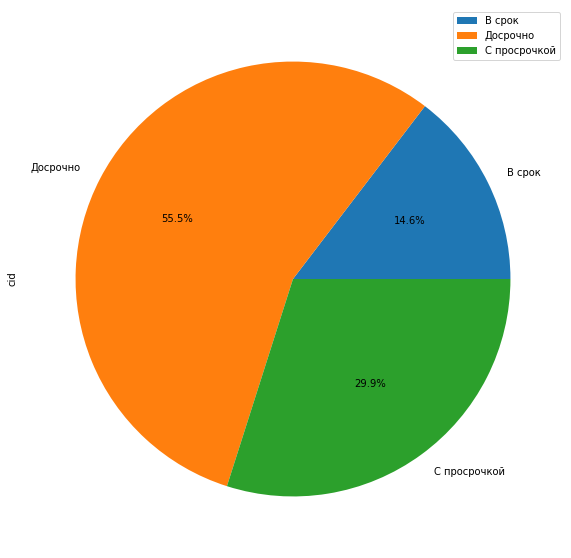

In [40]:
# та же диаграмма, но без статуса "Не закрыт"
loans.query('term_category != "Не закрыт"')\
.groupby('term_category').agg({'cid': 'count'}).plot(kind='pie', subplots=True, figsize=(10, 10), autopct='%1.1f%%');

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li> 29.9% не закрытых займов - цифра немного преувеличенная т.к. чем ближе анализируемый месяц к текущему - тем больше % невозвратов и наоборот.
        <li> если анализировать уже закрытые займы - 55.5% досрочно закрытых займов это большая цифра. И это как раз точка роста
    </ul>
</div>

### 4. Исследование суммы займов

#### 4.1 Базовые данные о сумме займов

In [41]:
print(f'Суммарные выдачи за анализируемый период составили {loans["value"].sum().round(0):,} рублей')

Суммарные выдачи за анализируемый период составили 4,335,232,940.0 рублей


In [42]:
# посмотрим на среднее, медиану, квартили и другие значения
loans['value'].describe()

count    448262.000000
mean       9671.203314
std        6748.788683
min        1500.000000
25%        4500.000000
50%        8000.000000
75%       13000.000000
max       80500.000000
Name: value, dtype: float64

In [43]:
# TOP10 частотность
loans['value'].value_counts().head(10)

8000.0     30589
10000.0    26879
4000.0     19368
5000.0     17059
12000.0    15628
3000.0     15424
2000.0     14507
6500.0     10270
3500.0      9518
15000.0     8811
Name: value, dtype: int64

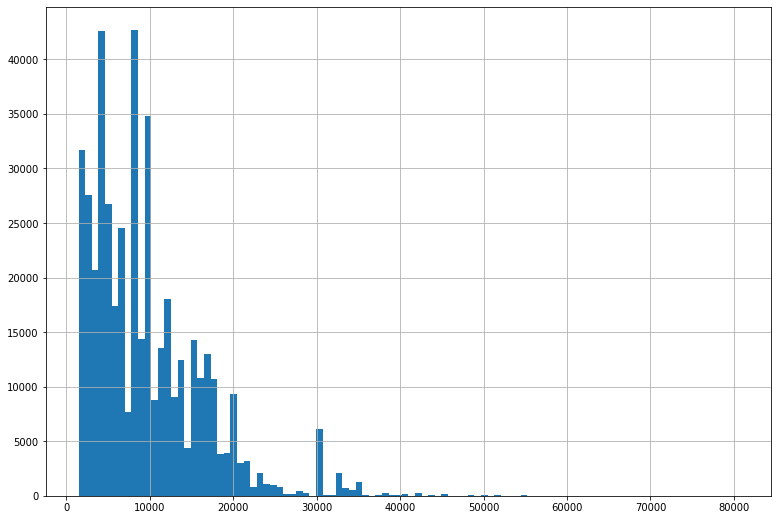

In [44]:
# посмотрим на распределение
loans['value'].hist(figsize=(13, 9), bins=100);

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li> общая сумма выданных средств за анализируемый период 4 335 232 940 рубля(ей)
        <li> средняя выдача - 9671 рублей
        <li> первый-третий квартили: 4500, 8000, 13000
        <li> чаще всего берут займ на 8000 рублей (30589 раз)
        <li> в ТОП10 значений по частоте 70% менее 10000 рублей
    </ul>
</div>

#### 4.2 Динамика измениня средней суммы займа

In [45]:
# группируем данные по месяцам, для каждого месяца считаем суммарный объем займов и количество займов
avg_loan_value = loans.groupby('loan_month').agg({'value': 'sum', 'cid': 'count'})

# переименуюем столбцы
avg_loan_value.columns=['total_value', 'total_loans']

# посчитаем средний чек
avg_loan_value['avg_loan_value'] = (avg_loan_value['total_value'] / avg_loan_value['total_loans']).astype('int')

avg_loan_value

,total_value,total_loans,avg_loan_value
loan_month,,,
2019-01-01,74823900.0,9157,8171
2019-02-01,114811600.0,13419,8555
2019-03-01,186953800.0,20770,9001
2019-04-01,228119200.0,23864,9559
2019-05-01,172281916.0,16360,10530
2019-06-01,126582760.0,13091,9669
2019-07-01,190280035.0,19330,9843
2019-08-01,203977264.0,19683,10363
2019-09-01,140698429.0,13197,10661


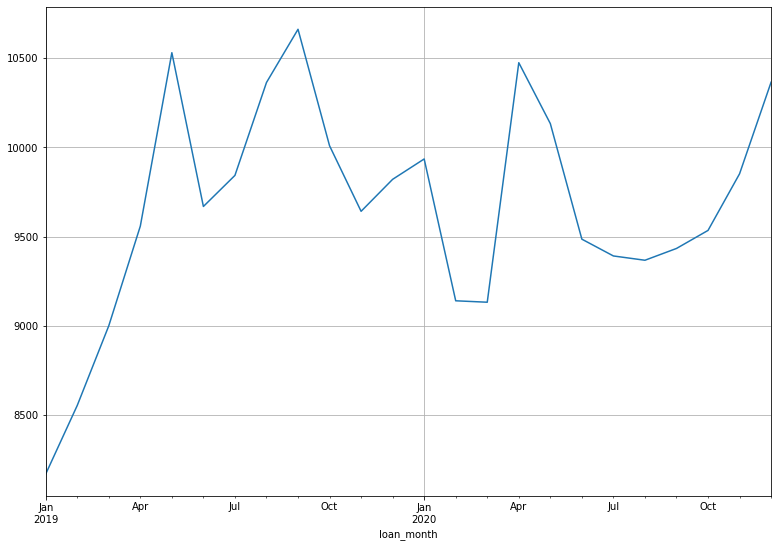

In [46]:
# посмотрим на чек в динамике
avg_loan_value['avg_loan_value'].plot(figsize=(13, 9), grid=True);

In [47]:
print(f'Минимальное занчение {avg_loan_value["avg_loan_value"].min()} рубл.')
print(f'Максимальное занчение {avg_loan_value["avg_loan_value"].max()} руб.')

Минимальное занчение 8171 рубл.
Максимальное занчение 10661 руб.


<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li> мин-макс средние значения находятся в диапазоне от 8171 руб до 10661 руб
        <li> не прослеживается какой-либо тренд на рост-падение, наблюдаюется рост-падение чека на 2-3к рублей
    </ul>
</div>

### 5. Когортный анализ

#### 5.1 Ретеншен

In [48]:
# для начала нам нужно выделить в отдельную таблицу месяц первого займа для каждого пользователя
loan_first_month = loans.sort_values(by=['cid', 'loan_month']).groupby(by='cid').agg({'loan_month': 'first'}).reset_index()

# переименуем столбцы
loan_first_month.columns = ['cid', 'loan_first_month']

# смотрим на результат
loan_first_month

,cid,loan_first_month
0,2825209,2019-01-01
1,2825218,2019-01-01
2,2825225,2019-03-01
3,2825230,2020-09-01
4,2825232,2019-07-01
...,...,...
186960,4706283,2020-11-01
186961,4706308,2020-12-01
186962,4706310,2020-12-01
186963,4706332,2020-11-01


In [49]:
# объеденим таблицы loans vs loan_first_month
loans = pd.merge(loans, loan_first_month, on='cid')

# добавим в таблицу столбец cohort_lifetime, который указывает на срок жизни когорты в месяцах
loans['cohort_lifetime'] =((loans['loan_month'] - loans['loan_first_month']) / np.timedelta64(1,'M'))\
.round().astype('int')

# смотрим на результат
loans.head()

,cid,start_date,value,term,status,end_date,loan_month,real_term,term_category,loan_first_month,cohort_lifetime
0,2825498,2019-08-20,30000.0,168,Погашен,2019-12-10,2019-08-01,112.0,Досрочно,2019-01-01,7
1,2825498,2019-01-03,4000.0,20,Погашен,2019-01-06,2019-01-01,3.0,Досрочно,2019-01-01,0
2,2825498,2020-05-29,19000.0,56,Погашен,2020-06-11,2020-05-01,13.0,Досрочно,2019-01-01,16
3,2825498,2019-01-22,4000.0,20,Погашен,2019-02-05,2019-01-01,14.0,Досрочно,2019-01-01,0
4,2825498,2019-02-10,6500.0,30,Погашен,2019-02-27,2019-02-01,17.0,Досрочно,2019-01-01,1


In [50]:
# создадим новую таблицу retention и сгруппируем в нее данные из таблицы loans
retention = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'cid': 'nunique'}).reset_index()

# переименуем колонки
retention.columns = ['loan_first_month', 'cohort_lifetime', 'active_users']

# смотрим результат
retention

,loan_first_month,cohort_lifetime,active_users
0,2019-01-01,0,7957
1,2019-01-01,1,2896
2,2019-01-01,2,2119
3,2019-01-01,3,1385
4,2019-01-01,4,682
...,...,...,...
295,2020-10-01,1,2710
296,2020-10-01,2,1777
297,2020-11-01,0,10219
298,2020-11-01,1,2192


In [51]:
# теперь в отдельной таблице сохраним пользователей нулевой когорты
initial_users = retention[retention['cohort_lifetime'] == 0][['loan_first_month', 'active_users']]

# переименуем столбцы
initial_users.columns = ['loan_first_month', 'initial_users']

# смотрим результат
initial_users

,loan_first_month,initial_users
0,2019-01-01,7957
24,2019-02-01,8879
47,2019-03-01,12222
69,2019-04-01,13328
90,2019-05-01,7258
110,2019-06-01,4995
129,2019-07-01,10059
147,2019-08-01,8585
164,2019-09-01,4140
180,2019-10-01,6106


In [52]:
# добавим в таблицу retention столбец initial_users из таблицы initial_users
retention = pd.merge(retention, initial_users, on='loan_first_month')

# рассчитаем retention_rate
retention['retention_rate'] = retention['active_users'] / retention['initial_users']

# смотрим финальную таблицу
retention.head()

,loan_first_month,cohort_lifetime,active_users,initial_users,retention_rate
0,2019-01-01,0,7957,7957,1.000000
1,2019-01-01,1,2896,7957,0.363956
2,2019-01-01,2,2119,7957,0.266306
3,2019-01-01,3,1385,7957,0.174061
4,2019-01-01,4,682,7957,0.085711


In [53]:
# группируем все в сводную таблицу
retention_pivot = retention.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                                        values='retention_rate', aggfunc='sum')

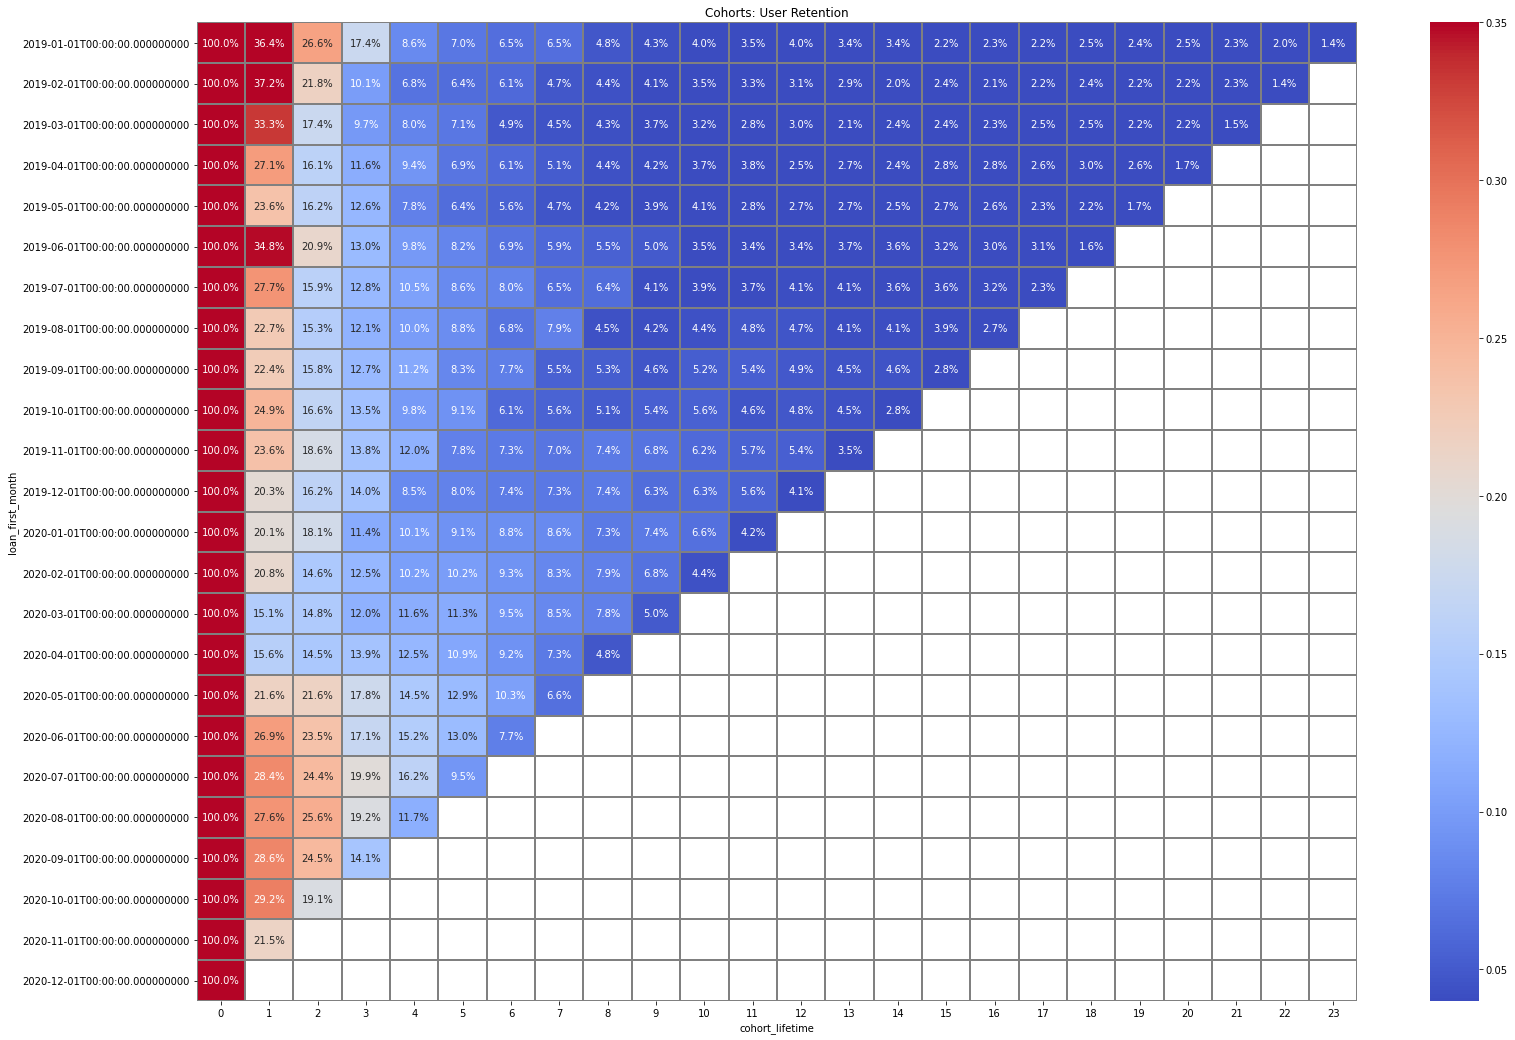

In [54]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmax=0.35, vmin=0.04);

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li> начало 2019 года имеет одни из самых лучших показателей
        <li> затем, начиная как раз с декабря 2019 показатели постепенно становтся хуже и дотигают минимальных значений к марту-апрелю 2020.
        <li> есть 2 вариант: корона и/или ухудшающиемя для клиентов условия
    </ul>
</div>

#### 5.2 Среднее кол-во займов

In [55]:
avg_loan_amount = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'cid': 'count'}).reset_index()
avg_loan_amount.rename(columns={'cid': 'cumsum_loans'}, inplace=True)
avg_loan_amount = pd.merge(avg_loan_amount, initial_users, on='loan_first_month')
avg_loan_amount['avg_loans'] = (avg_loan_amount['cumsum_loans'] / avg_loan_amount['initial_users']).round(2)

avg_loan_amount.head()

,loan_first_month,cohort_lifetime,cumsum_loans,initial_users,avg_loans
0,2019-01-01,0,9157,7957,1.15
1,2019-01-01,1,3497,7957,0.44
2,2019-01-01,2,2663,7957,0.33
3,2019-01-01,3,1658,7957,0.21
4,2019-01-01,4,771,7957,0.10


In [56]:
avg_loan_pivot = avg_loan_amount.pivot_table(index='loan_first_month', columns='cohort_lifetime', values='avg_loans', aggfunc='mean').cumsum(axis=1)

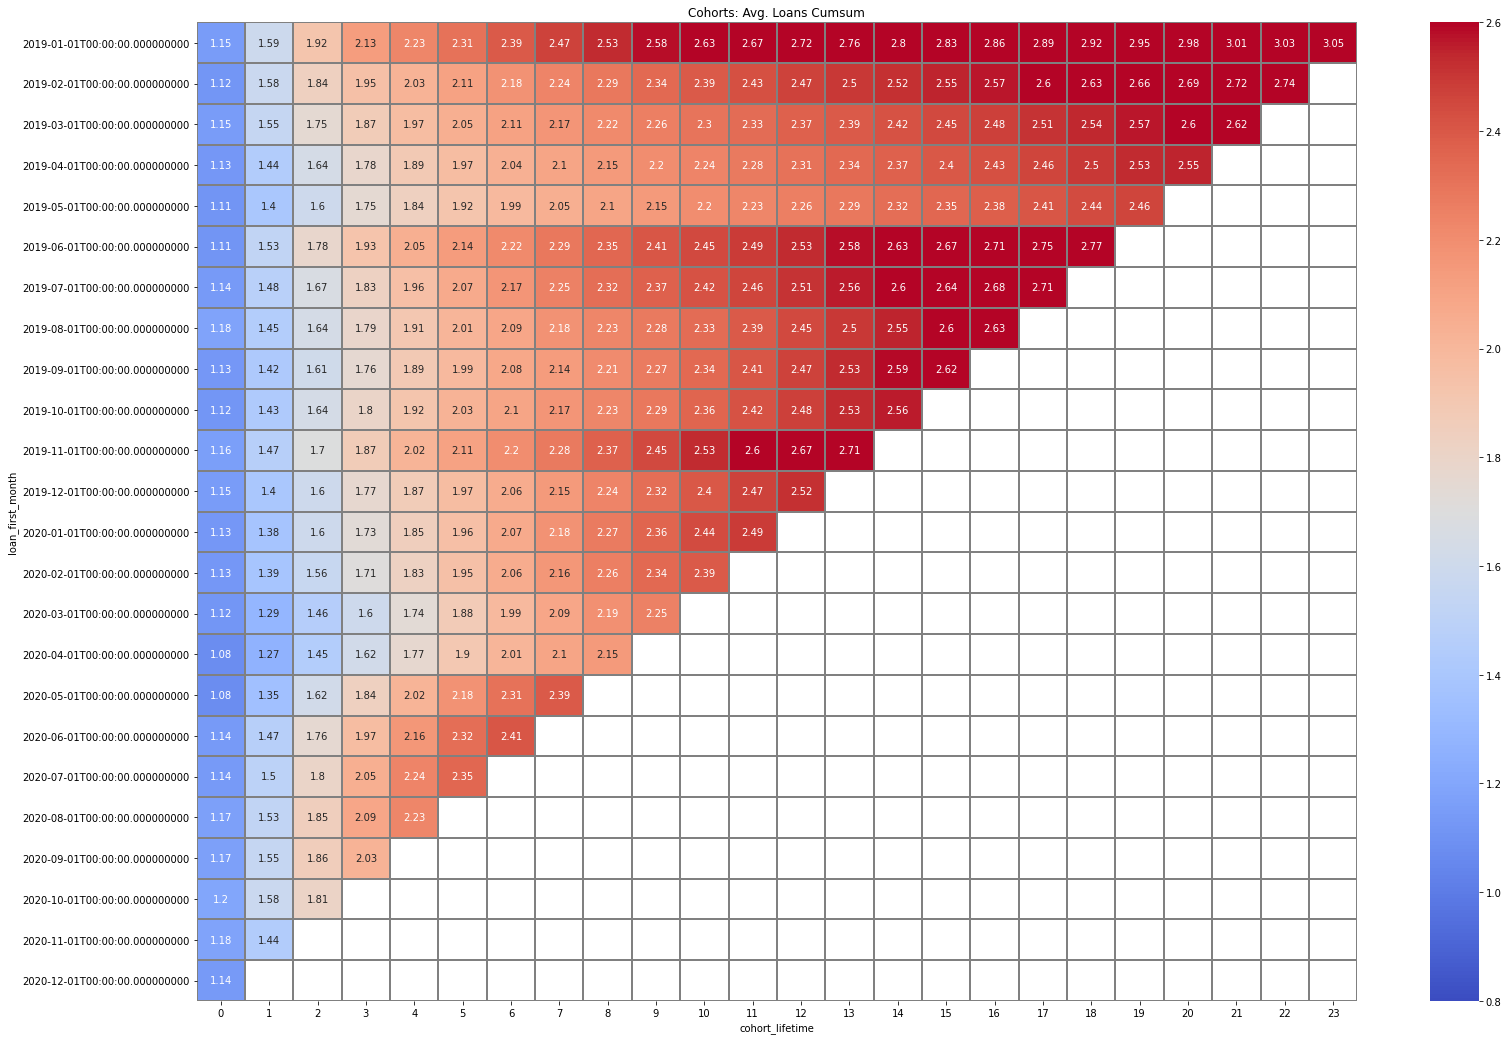

In [57]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: Avg. Loans Cumsum')
sns.heatmap(avg_loan_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=0.8, vmax=2.6);

#### 5.3 ARPU (Average Revenue per User)

In [58]:
arpu = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'value': 'sum'}).reset_index()
arpu = pd.merge(arpu, initial_users, on='loan_first_month')
arpu['arpu'] = ((arpu['value'] / arpu['initial_users'])/1000).round(2)

arpu.head()

,loan_first_month,cohort_lifetime,value,initial_users,arpu
0,2019-01-01,0,74823900.0,7957,9.40
1,2019-01-01,1,35037100.0,7957,4.40
2,2019-01-01,2,27916300.0,7957,3.51
3,2019-01-01,3,21167100.0,7957,2.66
4,2019-01-01,4,10443336.2,7957,1.31


In [59]:
arpu_pivot = arpu.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                              values='arpu', aggfunc='mean').cumsum(axis=1)

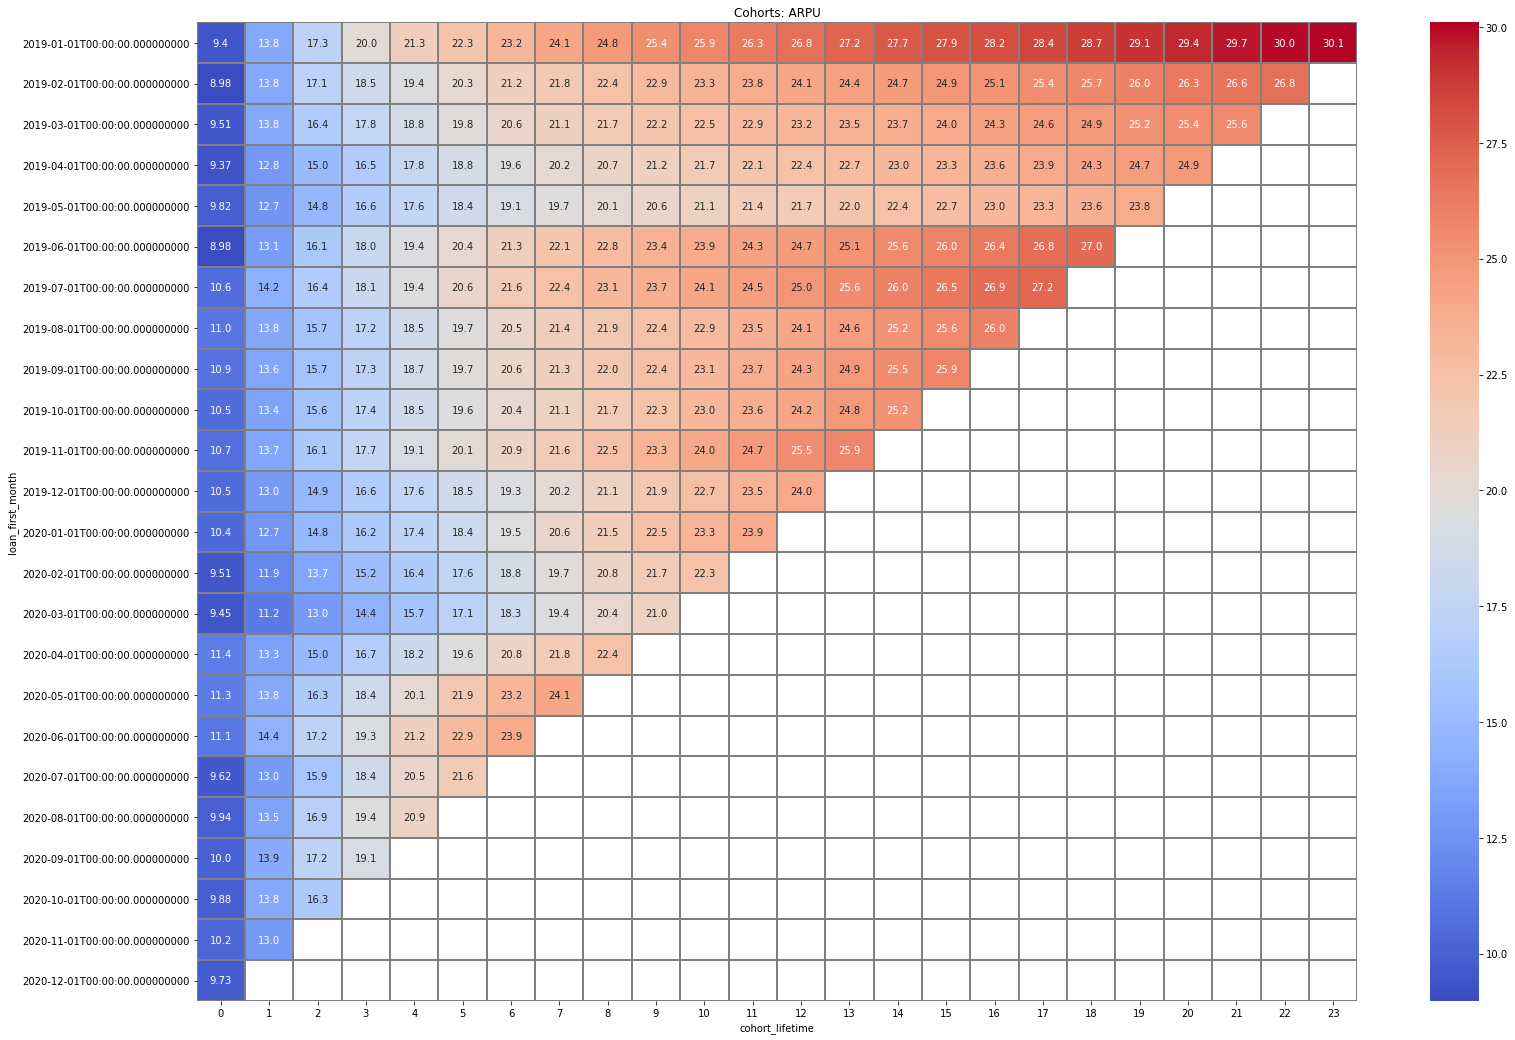

In [60]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: ARPU')
sns.heatmap(arpu_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm');

#### 5.4 Средняя сумма займа в конкретный месяц
почему с ростом lifetime "чек" не растет?

In [61]:
avg_loan_value = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'value': 'sum', 'cid': 'count'}).reset_index()
avg_loan_value['avg_loan_value'] = ((avg_loan_value['value'] / avg_loan_value['cid'])/1000).round(2)

avg_loan_value.head()

,loan_first_month,cohort_lifetime,value,cid,avg_loan_value
0,2019-01-01,0,74823900.0,9157,8.17
1,2019-01-01,1,35037100.0,3497,10.02
2,2019-01-01,2,27916300.0,2663,10.48
3,2019-01-01,3,21167100.0,1658,12.77
4,2019-01-01,4,10443336.2,771,13.55


In [62]:
avg_loan_value_pivot = avg_loan_value.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                              values='avg_loan_value', aggfunc='mean')

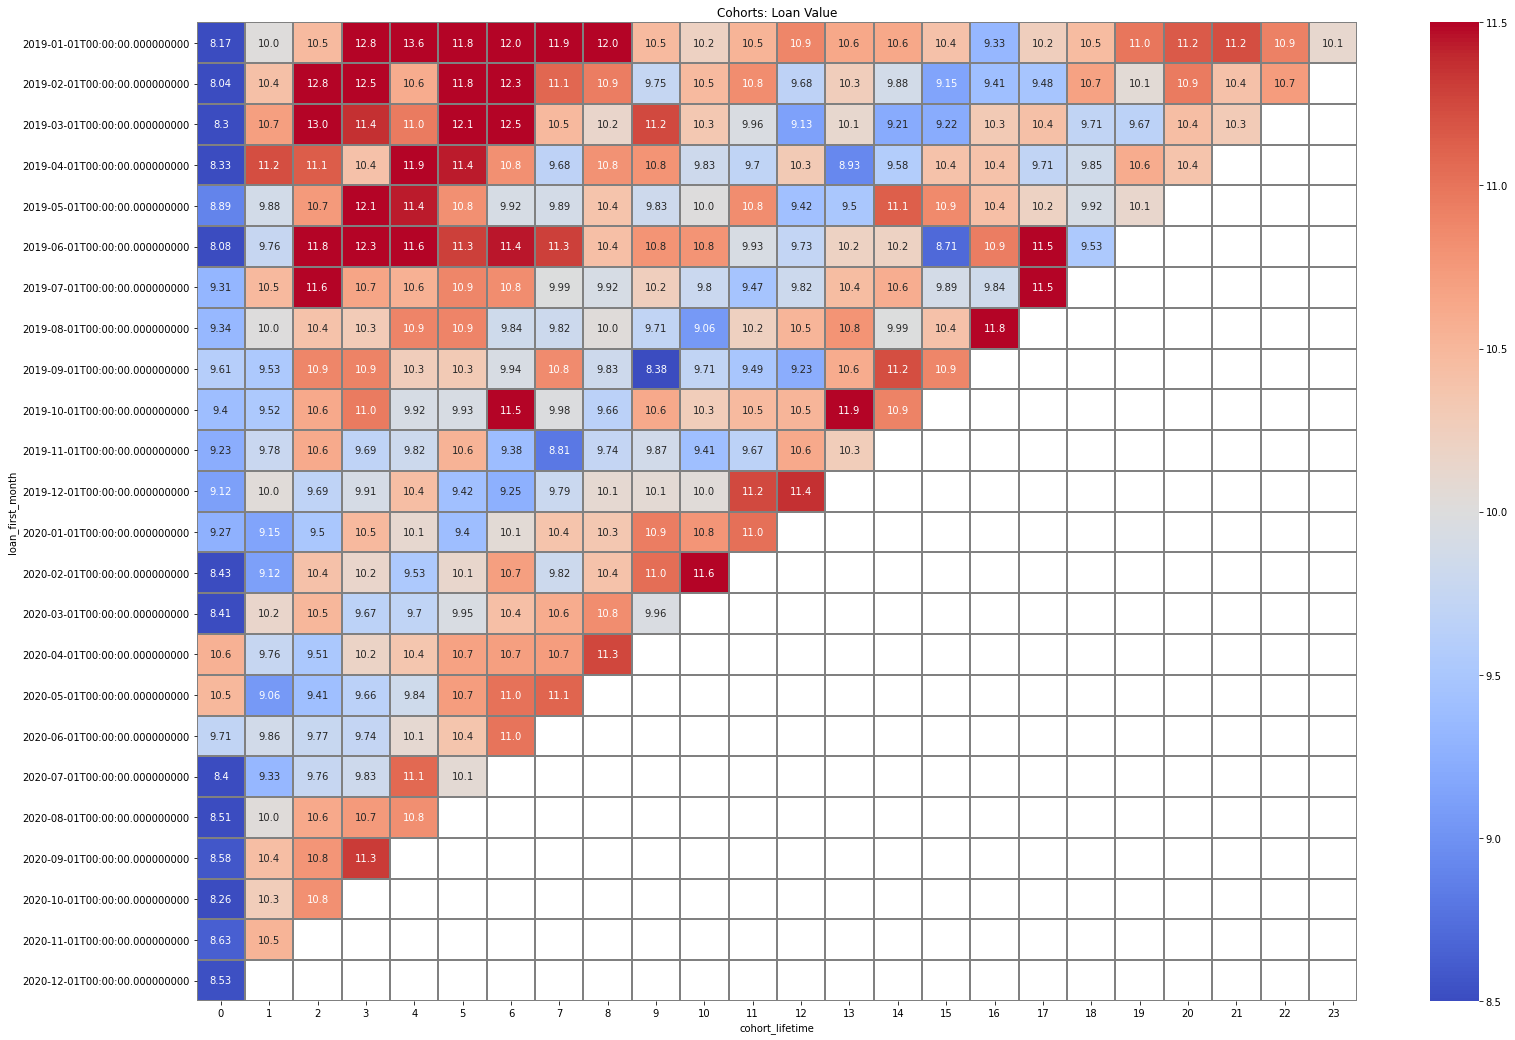

In [63]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: Loan Value')
sns.heatmap(avg_loan_value_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=8.5, vmax=11.5);

#### 5.4 Средняя сумма займа накопительным итогом

In [64]:
avg_cumsum_loan_value = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'value': 'sum', 'cid': 'count'})\
.groupby(level=0).cumsum().reset_index()
avg_cumsum_loan_value.rename(columns={'value': 'cumsum_value', 'cid': 'cumsum_loans'}, inplace=True)
avg_cumsum_loan_value['avg_cumsum_loan_value'] = ((avg_cumsum_loan_value['cumsum_value'] / avg_cumsum_loan_value['cumsum_loans'])/1000).round(2)

avg_cumsum_loan_value.head()

,loan_first_month,cohort_lifetime,cumsum_value,cumsum_loans,avg_cumsum_loan_value
0,2019-01-01,0,74823900.0,9157,8.17
1,2019-01-01,1,109861000.0,12654,8.68
2,2019-01-01,2,137777300.0,15317,9.00
3,2019-01-01,3,158944400.0,16975,9.36
4,2019-01-01,4,169387736.2,17746,9.55


In [65]:
avg_cumsum_loan_pivot = avg_cumsum_loan_value.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                              values='avg_cumsum_loan_value', aggfunc='mean')

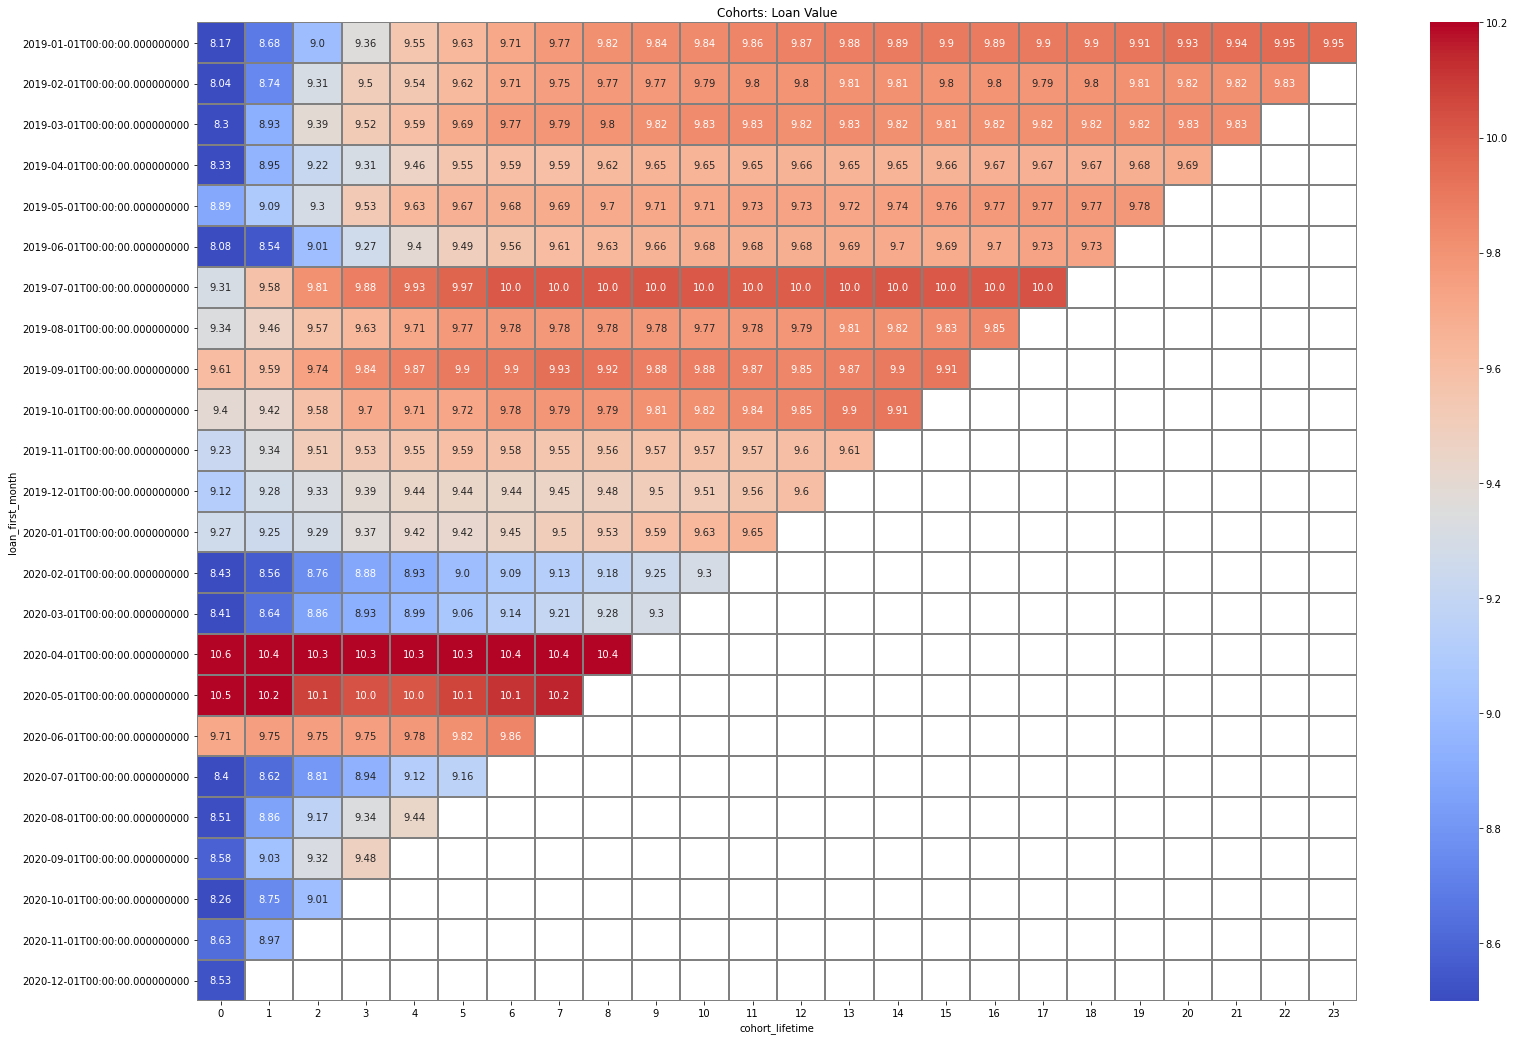

In [66]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: Loan Value')
sns.heatmap(avg_cumsum_loan_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=8.5, vmax=10.2);

#### 5.5 Оборотка нарастающим итогом

In [67]:
cumsum_value = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'value': 'sum', }).reset_index()
cumsum_value['value'] = (cumsum_value['value'] / 10000000).round(2)

cumsum_value

,loan_first_month,cohort_lifetime,value
0,2019-01-01,0,7.48
1,2019-01-01,1,3.50
2,2019-01-01,2,2.79
3,2019-01-01,3,2.12
4,2019-01-01,4,1.04
...,...,...,...
295,2020-10-01,1,3.65
296,2020-10-01,2,2.28
297,2020-11-01,0,10.45
298,2020-11-01,1,2.78


In [68]:
initial_value = cumsum_value[cumsum_value['cohort_lifetime'] == 0][['loan_first_month', 'value']]
initial_value.columns=['loan_first_month', 'initial_value']
initial_value

,loan_first_month,initial_value
0,2019-01-01,7.48
24,2019-02-01,7.98
47,2019-03-01,11.62
69,2019-04-01,12.49
90,2019-05-01,7.13
110,2019-06-01,4.49
129,2019-07-01,10.68
147,2019-08-01,9.45
164,2019-09-01,4.50
180,2019-10-01,6.41


In [69]:
cumsum_value = pd.merge(cumsum_value, initial_value, on='loan_first_month')
cumsum_value['value_gain'] = cumsum_value['value'] / cumsum_value['initial_value']

cumsum_value.head(20)

,loan_first_month,cohort_lifetime,value,initial_value,value_gain
0,2019-01-01,0,7.48,7.48,1.000000
1,2019-01-01,1,3.50,7.48,0.467914
2,2019-01-01,2,2.79,7.48,0.372995
3,2019-01-01,3,2.12,7.48,0.283422
4,2019-01-01,4,1.04,7.48,0.139037
5,2019-01-01,5,0.78,7.48,0.104278
6,2019-01-01,6,0.75,7.48,0.100267
7,2019-01-01,7,0.74,7.48,0.098930
8,2019-01-01,8,0.54,7.48,0.072193
9,2019-01-01,9,0.45,7.48,0.060160


In [70]:
cumsum_value_pivot = cumsum_value.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                         values='value_gain', aggfunc='mean').cumsum(axis=1)

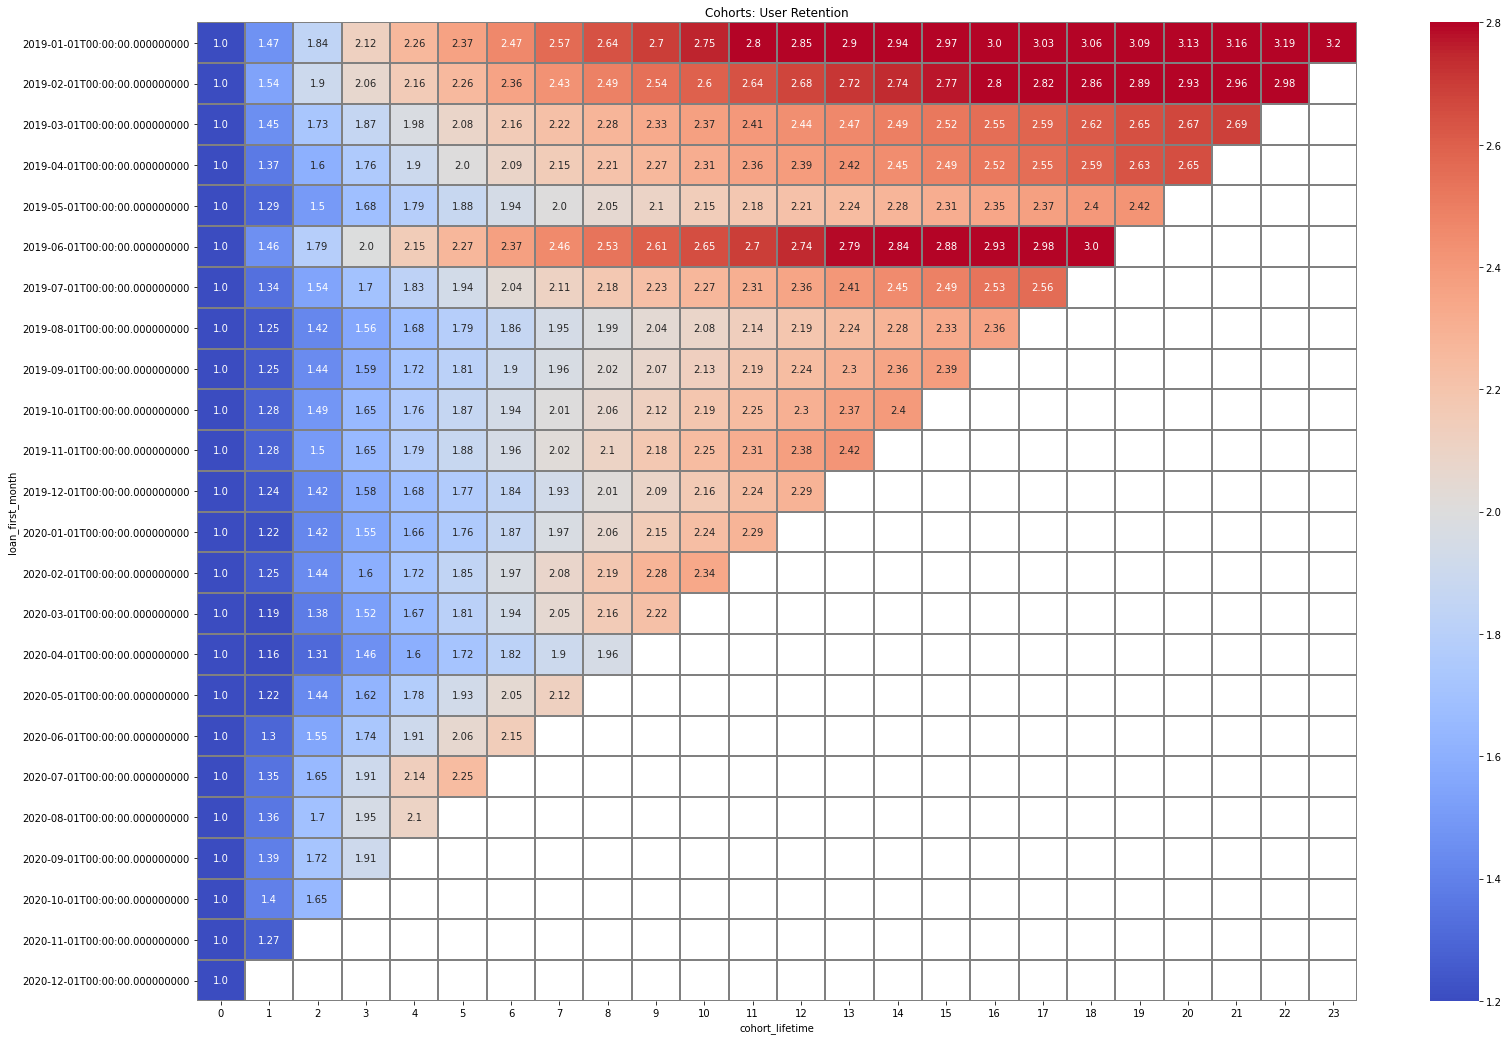

In [71]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: User Retention')
sns.heatmap(cumsum_value_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=1.2, vmax=2.8);

#### 5.6 NPL "наоборот"

In [72]:
loans['end_month'] = loans['end_date'].astype('datetime64[M]')
loans.head()

,cid,start_date,value,term,status,end_date,loan_month,real_term,term_category,loan_first_month,cohort_lifetime,end_month
0,2825498,2019-08-20,30000.0,168,Погашен,2019-12-10,2019-08-01,112.0,Досрочно,2019-01-01,7,2019-12-01
1,2825498,2019-01-03,4000.0,20,Погашен,2019-01-06,2019-01-01,3.0,Досрочно,2019-01-01,0,2019-01-01
2,2825498,2020-05-29,19000.0,56,Погашен,2020-06-11,2020-05-01,13.0,Досрочно,2019-01-01,16,2020-06-01
3,2825498,2019-01-22,4000.0,20,Погашен,2019-02-05,2019-01-01,14.0,Досрочно,2019-01-01,0,2019-02-01
4,2825498,2019-02-10,6500.0,30,Погашен,2019-02-27,2019-02-01,17.0,Досрочно,2019-01-01,1,2019-02-01


In [73]:
get_loans = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'cid': 'count'}).groupby(level=0).cumsum().reset_index()
get_loans.rename(columns={'cid': 'get_loans'}, inplace=True)
get_loans.head()

,loan_first_month,cohort_lifetime,get_loans
0,2019-01-01,0,9157
1,2019-01-01,1,12654
2,2019-01-01,2,15317
3,2019-01-01,3,16975
4,2019-01-01,4,17746


In [74]:
paid_loans = loans.groupby(['loan_first_month', 'end_month']).agg({'cid': 'count'}).groupby(level=0).cumsum().reset_index()
paid_loans['cohort_lifetime'] = ((paid_loans['end_month'] - paid_loans['loan_first_month']) / np.timedelta64(1,'M')).round().astype('int')
paid_loans.drop(columns='end_month', inplace=True)
paid_loans = paid_loans[['loan_first_month', 'cohort_lifetime', 'cid']]
paid_loans.rename(columns={'cid': 'paid_loans'}, inplace=True)

paid_loans.head()

,loan_first_month,cohort_lifetime,paid_loans
0,2019-01-01,0,2489
1,2019-01-01,1,7488
2,2019-01-01,2,10002
3,2019-01-01,3,11632
4,2019-01-01,4,12569


In [75]:
output = pd.merge(get_loans, paid_loans, on=['loan_first_month', 'cohort_lifetime'])
output['r_rate'] = (output['paid_loans'] / output['get_loans'])
output_pivot = output.pivot_table(index='loan_first_month', columns='cohort_lifetime', values='r_rate')

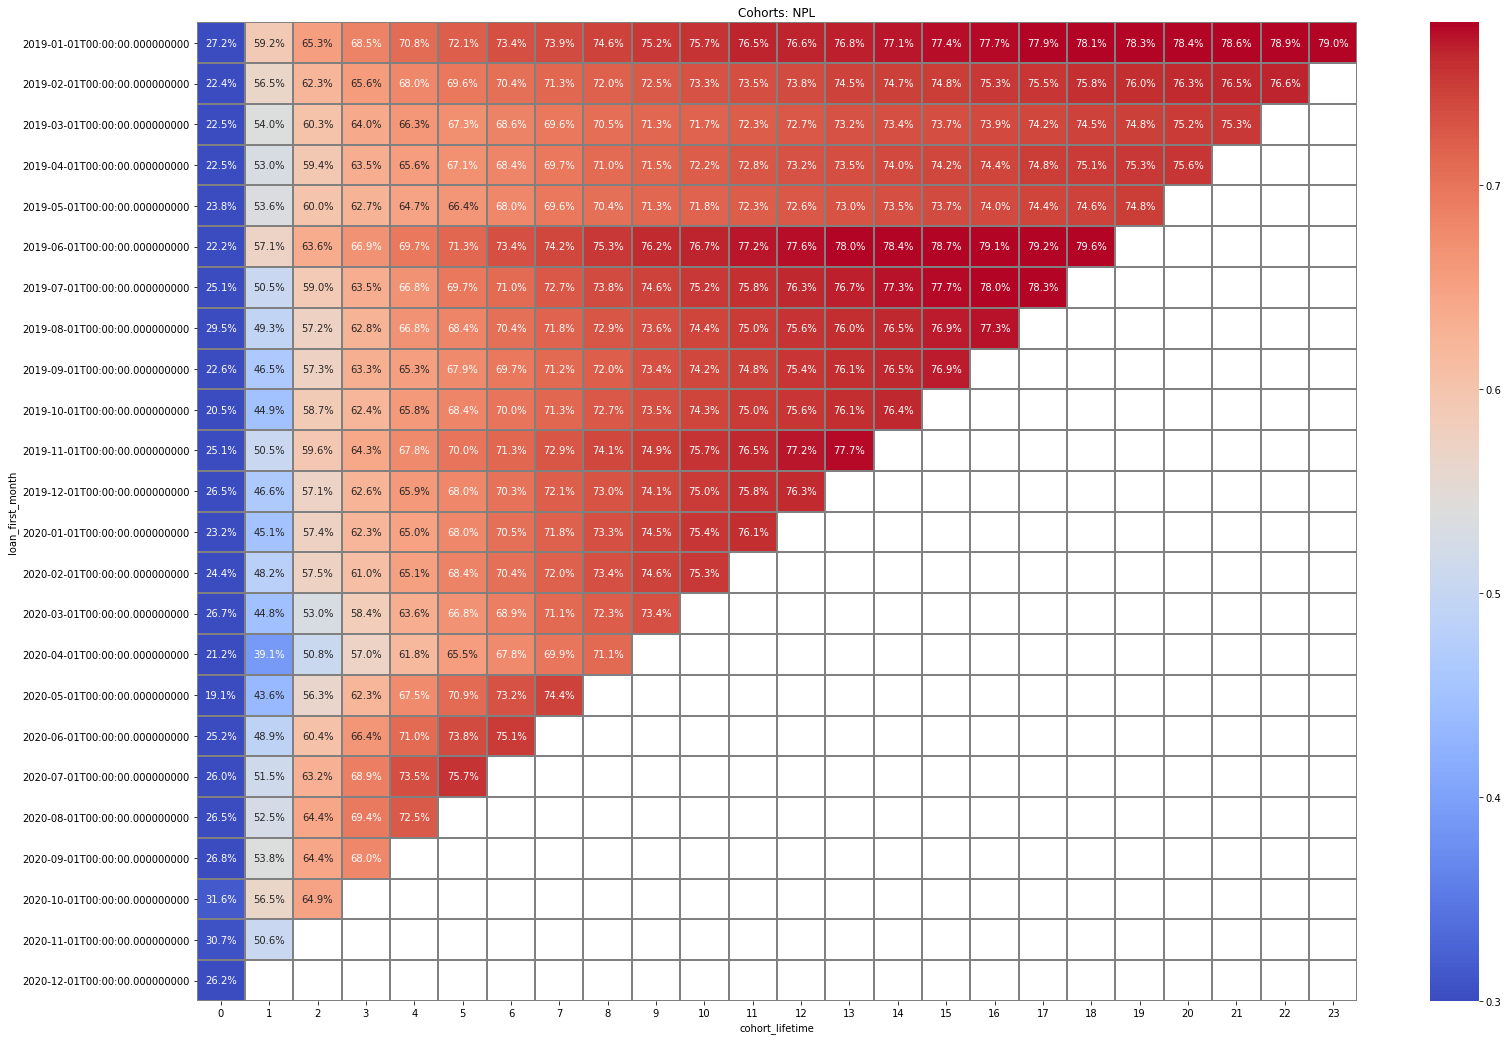

In [76]:
##### Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: NPL')
sns.heatmap(output_pivot, annot=True, fmt='.1%', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=0.3, vmax=0.78);

#### 5.6 Накопительное среднее количество дней пользование кредитом на уникального клиента

In [77]:
rt = loans.groupby(by=['loan_first_month', 'cohort_lifetime']).agg({'real_term': 'sum'}).reset_index()
rt

,loan_first_month,cohort_lifetime,real_term
0,2019-01-01,0,161760.0
1,2019-01-01,1,76559.0
2,2019-01-01,2,64747.0
3,2019-01-01,3,50862.0
4,2019-01-01,4,25974.0
...,...,...,...
295,2020-10-01,1,27724.0
296,2020-10-01,2,2938.0
297,2020-11-01,0,85059.0
298,2020-11-01,1,4112.0


In [78]:
rt_merge = pd.merge(rt, initial_users, how='left', on='loan_first_month')
rt_merge['avg_days'] = rt_merge['real_term'] / rt_merge['initial_users']
rt_merge

,loan_first_month,cohort_lifetime,real_term,initial_users,avg_days
0,2019-01-01,0,161760.0,7957,20.329270
1,2019-01-01,1,76559.0,7957,9.621591
2,2019-01-01,2,64747.0,7957,8.137112
3,2019-01-01,3,50862.0,7957,6.392108
4,2019-01-01,4,25974.0,7957,3.264296
...,...,...,...,...,...
295,2020-10-01,1,27724.0,9291,2.983963
296,2020-10-01,2,2938.0,9291,0.316220
297,2020-11-01,0,85059.0,10219,8.323613
298,2020-11-01,1,4112.0,10219,0.402388


In [79]:
rt_pivot = rt_merge.pivot_table(index='loan_first_month', columns='cohort_lifetime', values='avg_days').cumsum(axis=1)

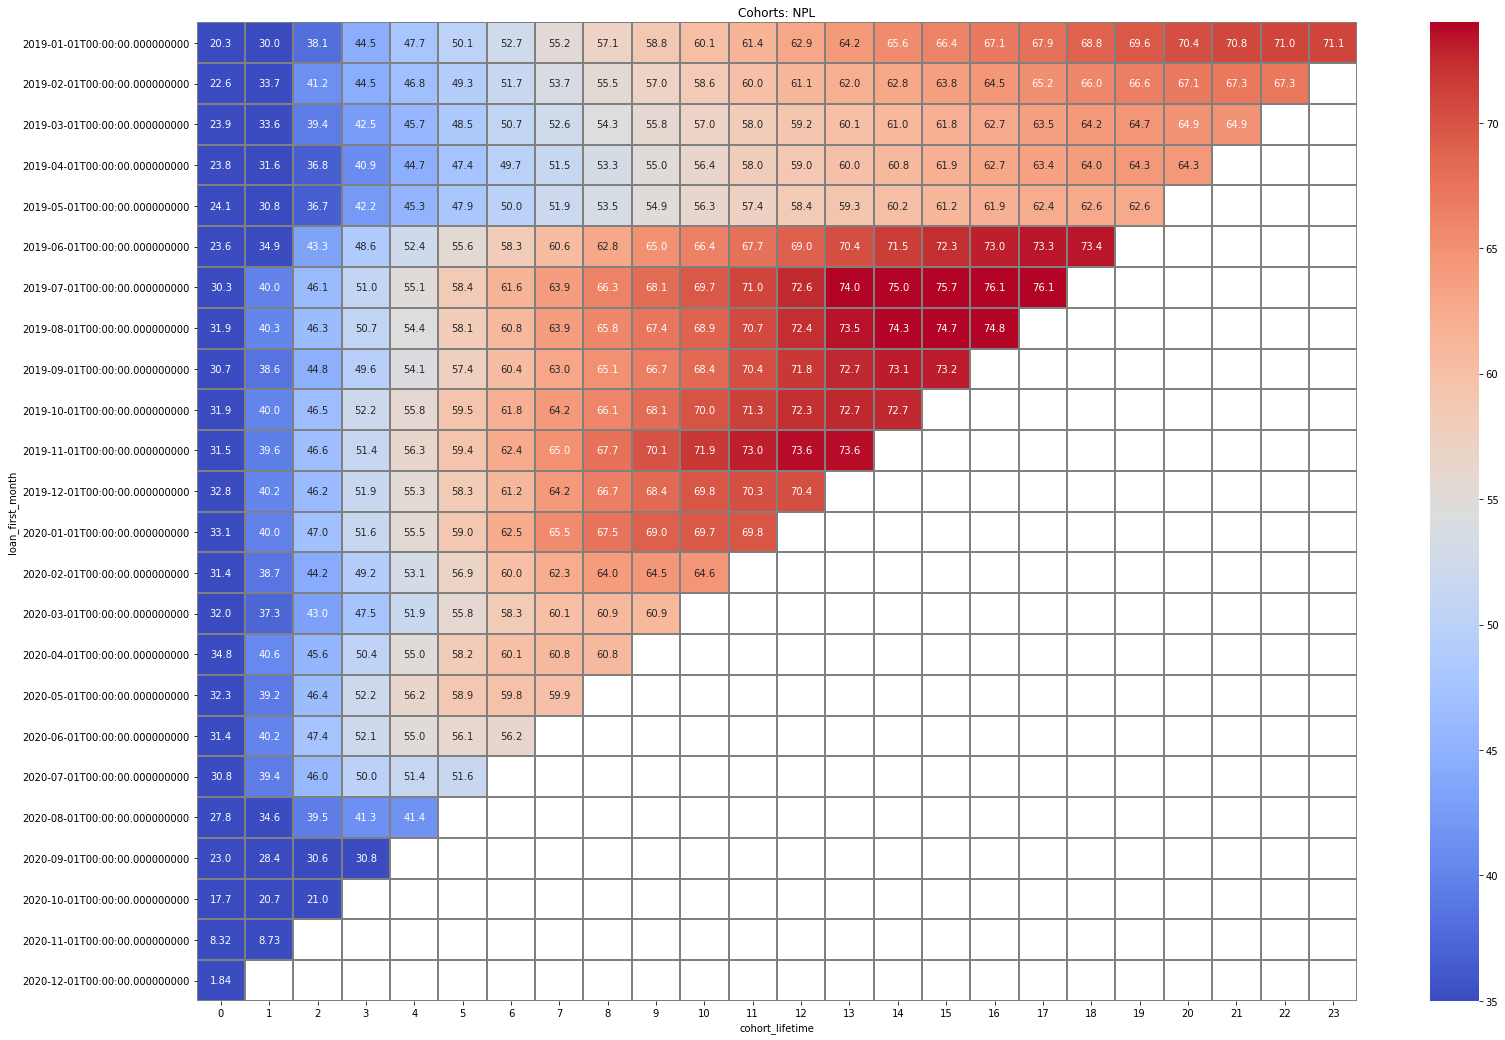

In [80]:
##### Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: NPL')
sns.heatmap(rt_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=35, vmax=74);

In [81]:
aa = loans.groupby(by='cid').agg({'start_date': 'count'}).sort_values(by='start_date', ascending=False).reset_index()
aa.head(10)

,cid,start_date
0,2976351,74
1,3603471,69
2,3685566,56
3,3041805,55
4,4000718,55
5,3982598,54
6,3709377,54
7,3162302,52
8,3096524,51
9,3260762,51


<AxesSubplot:>

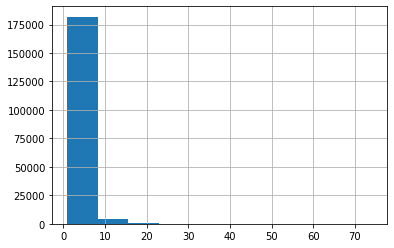

In [82]:
aa['start_date'].hist()

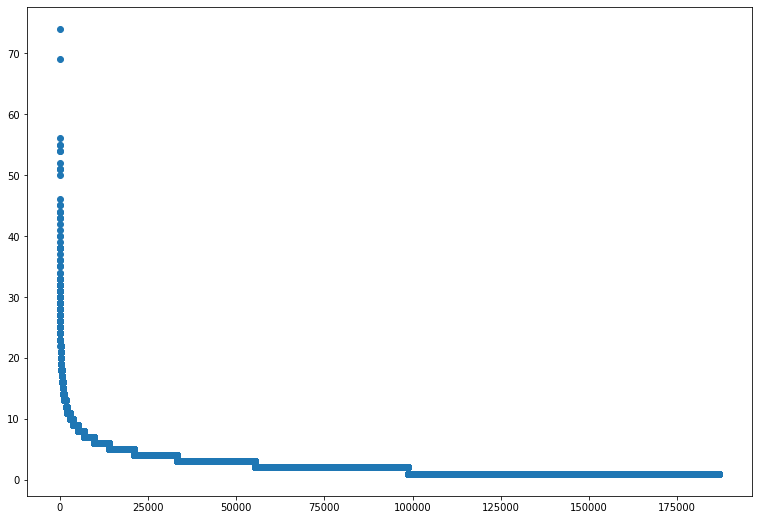

In [83]:
x_values = pd.Series(range(0,len(aa)))
plt.figure(figsize=(13, 9));
plt.scatter(x_values, aa['start_date']);

In [84]:
np.percentile(aa['start_date'], [25, 50, 75])

array([1., 2., 3.])

In [85]:
aa['start_date'].describe()

count    186965.000000
mean          2.397572
std           2.398077
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          74.000000
Name: start_date, dtype: float64

In [86]:
bb = loans.groupby(by='cid').agg({'real_term': 'sum'}).sort_values(by='real_term', ascending=False).reset_index()
bb.head(10)

,cid,real_term
0,2885127,689.0
1,2983562,684.0
2,2947321,666.0
3,2943604,664.0
4,2846255,661.0
5,2980482,656.0
6,3078299,653.0
7,2940360,650.0
8,2998308,648.0
9,3024327,646.0


<AxesSubplot:>

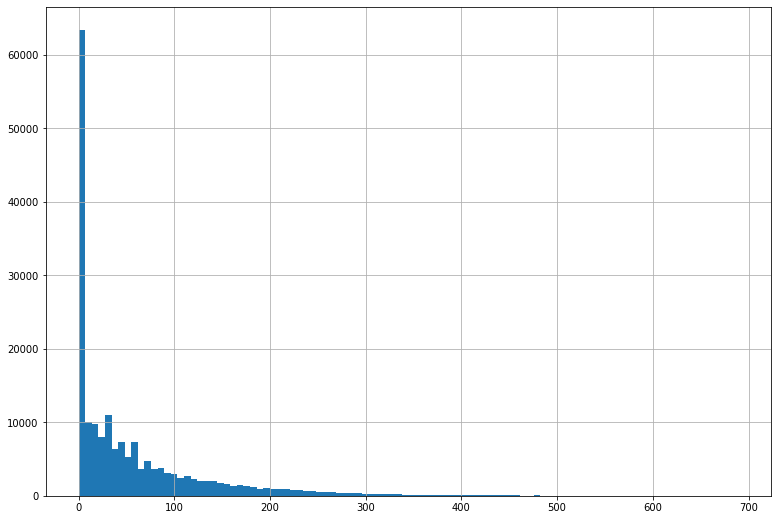

In [87]:
bb['real_term'].hist(bins=100, figsize=(13, 9))

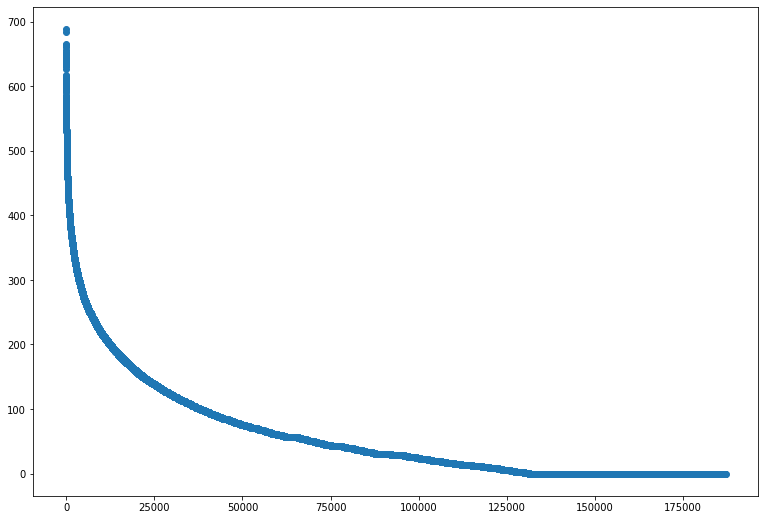

In [88]:
x_values = pd.Series(range(0,len(bb)))
plt.figure(figsize=(13, 9));
plt.scatter(x_values, bb['real_term']);

In [89]:
bb['real_term'].describe()

count    186965.000000
mean         57.772225
std          78.707538
min           0.000000
25%           0.000000
50%          29.000000
75%          82.000000
max         689.000000
Name: real_term, dtype: float64

In [90]:
bb['real_term'].value_counts()

0.0      55724
30.0      3197
56.0      2667
42.0      2414
28.0      1947
         ...  
642.0        1
646.0        1
648.0        1
650.0        1
598.0        1
Name: real_term, Length: 607, dtype: int64

In [91]:
loans.head(20)

,cid,start_date,value,term,status,end_date,loan_month,real_term,term_category,loan_first_month,cohort_lifetime,end_month
0,2825498,2019-08-20,30000.0,168,Погашен,2019-12-10,2019-08-01,112.0,Досрочно,2019-01-01,7,2019-12-01
1,2825498,2019-01-03,4000.0,20,Погашен,2019-01-06,2019-01-01,3.0,Досрочно,2019-01-01,0,2019-01-01
2,2825498,2020-05-29,19000.0,56,Погашен,2020-06-11,2020-05-01,13.0,Досрочно,2019-01-01,16,2020-06-01
3,2825498,2019-01-22,4000.0,20,Погашен,2019-02-05,2019-01-01,14.0,Досрочно,2019-01-01,0,2019-02-01
4,2825498,2019-02-10,6500.0,30,Погашен,2019-02-27,2019-02-01,17.0,Досрочно,2019-01-01,1,2019-02-01
5,2825498,2019-01-07,2500.0,7,Погашен,2019-01-08,2019-01-01,1.0,Досрочно,2019-01-01,0,2019-01-01
6,2825498,2019-02-28,30000.0,168,Погашен,2019-05-23,2019-02-01,84.0,Досрочно,2019-01-01,1,2019-05-01
7,2825498,2019-07-01,10000.0,15,Погашен,2019-07-12,2019-07-01,11.0,Досрочно,2019-01-01,6,2019-07-01
8,2825498,2020-04-09,12000.0,56,Погашен,2020-05-21,2020-04-01,42.0,Досрочно,2019-01-01,15,2020-05-01
9,2825498,2019-01-09,4000.0,15,Погашен,2019-01-21,2019-01-01,12.0,Досрочно,2019-01-01,0,2019-01-01
